In [55]:
# base code from 
# 1: https://docs.opencv.org/4.x/da/d0c/tutorial_bounding_rects_circles.html
# 2: https://pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/
# 3: https://www.geeksforgeeks.org/python/python-play-a-video-using-opencv/

In [56]:
# import the necessary packages
from scipy.spatial import distance as dist  # provides functions for computing distances
from collections import OrderedDict 
import numpy as np  # y'all already know
from __future__ import print_function
import cv2 as cv
import argparse
import random as rng
import matplotlib.pyplot as plt

print("hi")

hi


In [57]:
def thresh_callback(val, frame):
    threshold = val

    canny_output = cv.Canny(frame, threshold, threshold * 2)

    contours, _ = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # print(len(contours))

    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        # print(len(boundRect[i]))
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])

    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours_poly, i, color)
        cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        # cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

    cv.imshow('Contours', drawing)
    # print(boundRect)
    return boundRect

In [58]:
class CentroidTracker():
	def __init__(self, maxDisappeared=100):
		self.objects = OrderedDict()
		self.nextObjectID = 0
		self.disappeared = OrderedDict()
		self.Positions = OrderedDict()
		self.maxDisappeared = maxDisappeared
	
	def update_Positions(self,frameNumber,CX,CY):
		objectIDs = list(CX.keys())
    	# objectCentroids = list(self.objects.values())
		for ID in objectIDs:
			if ID in self.Positions:
				self.Positions[ID] = np.append(self.Positions[ID],np.array([[frameNumber,CX[ID],CY[ID]]]),axis=0)
			else:
				self.Positions[ID] = np.array([[frameNumber,CX[ID],CY[ID]]])
	
	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1
	
	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]
	
	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1
				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)
			# return early as there are no centroids or tracking info
			# to update
			return self.objects

        # initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype='int')
        # loop over the bounding box rectangles
		CX = OrderedDict()
		CY = OrderedDict()
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

        # if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])
        # otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())
			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)
			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value is at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()
			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()
			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue
				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				CX[objectID] = inputCentroids[col][0]
				CY[objectID] = inputCentroids[col][1]
				self.disappeared[objectID] = 0
				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)
			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)   
            # in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1
					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)
            # otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])
		# return the set of trackable objects
		return self.objects, CX, CY

In [59]:
def init_video(filename, thresh):
    # Create a VideoCapture object and read from input file
    cap = cv.VideoCapture(filename)
    
    # Check if camera opened successfully
    if (cap.isOpened()== False):
        print("Error opening video file")
    cTracker = CentroidTracker()
    fgbg = cv.bgsegm.createBackgroundSubtractorMOG()

    # Read until video is completed
    t=0
    a=7;
    kernel1 = cv.getStructuringElement(cv.MORPH_RECT,(a,a))
    # kernel2 = cv.getStructuringElement(cv.MORPH_CROSS,(a,a))
    # kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(a,a))
    numGuys = []
    frameDim = 500;
    while(cap.isOpened()):
        t+=1
    # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            fgmask = fgbg.apply(frame)
            fgmask1 = cv.morphologyEx(fgmask, cv.MORPH_OPEN, kernel1)
            # fgmask2 = cv.morphologyEx(fgmask, cv.MORPH_OPEN, kernel2)
            # fgmask3 = cv.morphologyEx(fgmask, cv.MORPH_OPEN, kernel3)
            cv.imshow('frame1',fgmask1)
            # cv.resizeWindow('frame1', frameDim,frameDim)
            # cv.imshow('frame2',fgmask2)
            # cv.resizeWindow('frame2', frameDim,frameDim)
            # cv.imshow('frame3',fgmask3)
            # cv.resizeWindow('frame3', frameDim,frameDim)
            #k = cv.waitKey(30) & 0xff

            # Display the resulting frame
            rects = thresh_callback(thresh, fgmask1)
            cv.resizeWindow('Contours', frameDim,frameDim)

            if not rects:
                continue
            objects,CX,CY = cTracker.update(rects)
            numGuys.append(len(objects))
            cTracker.update_Positions(t,CX,CY)
            # print(len(rects))
            # Press Q on keyboard to exit
            if cv.waitKey(25) & 0xFF == ord('q'):
                break

    # Break the loop
        else:
            break
    
    # When everything done, release
    # the video capture object
    cap.release()
    # print(cTracker.Positions)
    # K=(len(list(cTracker.Positions.keys())))
    # print(K)
    # print("------------------------")
    # for k in list(cTracker.Positions.keys()):
    #     print(np.size(cTracker.Positions[k])/3)
    # Closes all the frames
    cv.destroyAllWindows()
    return numGuys

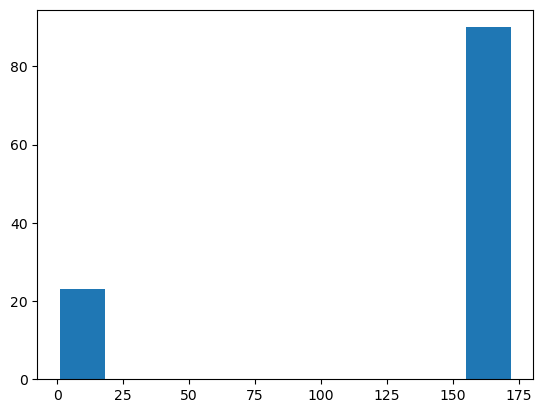

In [60]:
numGuys = init_video("vid2.mp4", 200)
plt.hist(numGuys)
plt.show() 
